In [538]:
import pandas as pd
import numpy as np
from pandas import DataFrame, HDFStore
import matplotlib.pyplot as plt
import datetime as dt

In [720]:
class keyratios:
    def __init__(self,filename):
        self.load(filename)
    
    def load_keyratios(self,filename):
        try:
            self.keyratios = pd.read_csv(filename,skiprows=2)
        except IOError:
            self.keyratios = None
            return
        self._correct_colnames()
        self.keyratios = self.format_keyratios()
    
    def _correct_colnames(self):
        newcols = []
        for i in self.keyratios.columns:
            if i == 'TTM':
                newcols.append(newcols[-1]+1)
                continue
            if 'Unnamed' in i:
                newcols.append('year')
                continue 
            newcols.append(int(i.split('-')[0]))
        self.keyratios.columns = newcols

    def format_keyratios(self):
        pdf = self.keyratios
        pdf = pdf.transpose()
        
        cols_new     = []
        cols_to_use  = []

        cols_old = np.array(pdf[pdf.index=='year'])[0]
        for string in cols_old:
    #         print string
            try:
                newstring = string
                newstring = newstring.replace(' ','')
                newstring = newstring.replace('%', '')
                newstring = newstring.replace('Mil','')
                newstring = newstring.replace('*','')
                newstring = newstring.replace('(','')
                newstring = newstring.replace(')','')

                for j in currencies.currency:
                    newstring = newstring.replace(j,'')
            except AttributeError:
                newstring = 'NaN'

            if newstring in cols_new:
                newstring = '{0}_{1}'.format(newstring,len(cols_new)+1)
            cols_new.append(newstring)    

        try:
            pdf.columns = cols_new
        except ValueError:
            return cols_old,cols_new
        pdf         = pdf[1:]


        for c in cols_new:
            if '_' not in c and '&' not in c:
                if c not in ['NaN','3-YearAverage','Efficiency','MarginsofSales','Growth',
                             'BalanceSheetItemsin','Liquidity/FinancialHealth','Profitability',
                             'CashFlowRatios']:
                    cols_to_use.append(c)


        pdf = pdf[cols_to_use]
        pdf = pdf.replace(to_replace=",",value="",regex=True)    


        pdf = pdf.astype('float')


        pdf = pdf[[
                    'Shares',
                    'Revenue',
                    'EarningsPerShare',
                    'Dividends',
                    'BookValuePerShare',
                    'OperatingCashFlow',
                    'EBTMargin',
                    'FreeCashFlow',
                    'ReturnonEquity',
                    'GrossMargin',
                    'OperatingIncome', 
                    'OperatingMargin',
                    'NetIncome',
                    'NetMargin',
                    'CapSpending',
                    'FreeCashFlow', 
                    'FreeCashFlowPerShare', 
                    'WorkingCapital', 
                    'COGS',
                    'EBTMargin', 
                    'TaxRate', 
                    'NetMargin',
                    'AssetTurnoverAverage', 
                    'ReturnonAssets',
                    'FinancialLeverageAverage',
                    'ReturnonEquity', 
                    'ReturnonInvestedCapital', 
                    'InterestCoverage' 
                   ]]


        return pdf    

In [721]:
class stocks(keyratios):
    def __init__(self,stocklist,index=0,ISIN=None,verbose=False):
        self.list  = pd.read_csv(stocklist)

        if ISIN:
            self.switch_isin(ISIN)
        else:
            self.switch_index(index)
        self._update_tables()
        
    def switch_isin(self,isin):
        df         = self.list[self.list.ISIN==isin]
        self.index = df.index[0]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._update_tables()
        
    def switch_index(self,index):
        self.index = index
        df         = self.list[self.list.index==index]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._update_tables()
        
    def switch_next(self):
        self.switch_index(self.index+1)
        self._update_tables()

    def _update_tables(self):
        try:
            self.load_keyratios('ms_keyratios/'+self.ticker+'.csv')
        except:
            self.keyratios = None

In [739]:
hdf = HDFStore('database/stockdb.h5')

In [781]:

s = stocks('XETRA.csv')
for i in range(0,4):
    s.switch_next()
# s.switch_next()
# s.switch_next()
print s.index, s.name, s.isin, s.ticker
# s.load_keyratios('ms_keyratios/{0}.csv'.format(s.ticker))
# except:
#     print 'COULD NOT LOAD KEYRATIOS'
#     pass

# s.switch_next()
# s.switch_next()
# print s.index, s.name, s.isin, s.ticker

# s.keyratios.head()


4 ORTHOFIX INT.      DL-,10 ANN6748L1027 OFX


In [782]:
s.keyratios

,Shares,Revenue,EarningsPerShare,Dividends,BookValuePerShare,OperatingCashFlow,EBTMargin,FreeCashFlow,ReturnonEquity,GrossMargin,...,COGS,EBTMargin,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonEquity,ReturnonInvestedCapital,InterestCoverage
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.98,NaN,NaN,NaN
2014,234.0,77.0,0.07,NaN,0.10,68.0,28.52,68.0,52.69,92.6,...,7.41,28.52,27.03,20.81,0.59,12.18,4.56,52.69,49.02,NaN
2015,242.0,NaN,0.10,0.08,0.18,39.0,NaN,33.0,58.03,NaN,...,NaN,NaN,28.49,NaN,NaN,13.60,4.04,58.03,55.03,NaN
2016,243.0,NaN,0.09,0.10,0.21,16.0,NaN,6.0,43.26,NaN,...,NaN,NaN,31.39,NaN,NaN,10.96,3.86,43.26,40.99,NaN


In [768]:
s.keyratios

In [746]:
hdf_key = HDFStore('database/keyratios.h5')

In [744]:
hdf_key.append(s.isin,s.keyratios)

In [745]:
hdf_key.close()

In [748]:
s.isin

'ANN4327C1220'

In [747]:
hdf_key['ANN4327C1220']

,Shares,Revenue,EarningsPerShare,Dividends,BookValuePerShare,OperatingCashFlow,EBTMargin,FreeCashFlow,ReturnonEquity,GrossMargin,...,COGS,EBTMargin,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonEquity,ReturnonInvestedCapital,InterestCoverage
2006,42.0,2630.0,7.78,NaN,24.45,304.0,15.93,197.0,22.02,43.2,...,57.76,15.93,21.62,12.42,1.01,12.53,1.69,22.02,16.72,14.88
2007,42.0,3028.0,7.34,NaN,28.26,63.0,12.19,-85.0,16.69,41.3,...,59.38,12.19,15.99,10.20,0.94,9.62,1.77,16.69,12.53,10.22
2008,38.0,2942.0,-0.95,NaN,38.95,26.0,-1.12,-109.0,-2.17,37.5,...,63.29,-1.12,NaN,-1.19,0.95,-1.14,2.14,-2.17,5.25,0.81
2009,35.0,2376.0,2.54,NaN,NaN,184.0,3.91,120.0,6.81,36.9,...,63.09,3.91,2.15,3.79,0.93,3.53,1.74,6.81,4.83,6.47
2010,35.0,2445.0,4.31,1.04,23.41,-186.0,6.38,-257.0,12.09,39.0,...,61.02,6.38,1.28,6.26,1.02,6.35,2.10,12.09,8.37,10.75
2011,35.0,2573.0,2.19,1.81,25.40,117.0,2.80,1.0,6.79,38.7,...,61.25,2.80,NaN,3.03,1.05,3.19,2.16,6.79,6.39,2.64
2012,35.0,2588.0,2.90,1.58,24.90,101.0,4.68,24.0,9.06,38.9,...,61.05,4.68,15.70,3.99,1.03,4.13,2.23,9.06,5.78,NaN
2013,35.0,2636.0,3.08,1.63,23.24,162.0,5.16,91.0,9.65,40.1,...,60.55,5.16,21.32,4.06,1.13,4.60,1.97,9.65,6.74,NaN
2014,35.0,2695.0,3.59,1.71,26.16,93.0,5.64,19.0,11.50,39.7,...,61.08,5.64,17.76,4.64,1.18,5.49,2.23,11.50,8.37,NaN
2015,35.0,2552.0,4.49,1.51,26.63,157.0,8.07,97.0,14.75,41.8,...,58.62,8.07,24.76,6.11,1.13,6.88,2.06,14.75,11.10,14.73


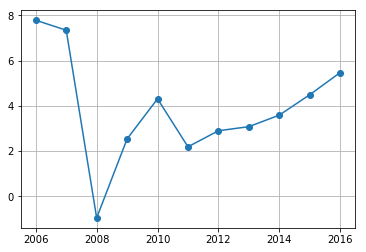

In [725]:
plt.plot(s.keyratios.index,s.keyratios.EarningsPerShare,'o-')
plt.grid()
plt.show()

In [726]:
s.keyratios

,Shares,Revenue,EarningsPerShare,Dividends,BookValuePerShare,OperatingCashFlow,EBTMargin,FreeCashFlow,ReturnonEquity,GrossMargin,...,COGS,EBTMargin,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonEquity,ReturnonInvestedCapital,InterestCoverage
2006,42.0,2630.0,7.78,NaN,24.45,304.0,15.93,197.0,22.02,43.2,...,57.76,15.93,21.62,12.42,1.01,12.53,1.69,22.02,16.72,14.88
2007,42.0,3028.0,7.34,NaN,28.26,63.0,12.19,-85.0,16.69,41.3,...,59.38,12.19,15.99,10.20,0.94,9.62,1.77,16.69,12.53,10.22
2008,38.0,2942.0,-0.95,NaN,38.95,26.0,-1.12,-109.0,-2.17,37.5,...,63.29,-1.12,NaN,-1.19,0.95,-1.14,2.14,-2.17,5.25,0.81
2009,35.0,2376.0,2.54,NaN,NaN,184.0,3.91,120.0,6.81,36.9,...,63.09,3.91,2.15,3.79,0.93,3.53,1.74,6.81,4.83,6.47
2010,35.0,2445.0,4.31,1.04,23.41,-186.0,6.38,-257.0,12.09,39.0,...,61.02,6.38,1.28,6.26,1.02,6.35,2.10,12.09,8.37,10.75
2011,35.0,2573.0,2.19,1.81,25.40,117.0,2.80,1.0,6.79,38.7,...,61.25,2.80,NaN,3.03,1.05,3.19,2.16,6.79,6.39,2.64
2012,35.0,2588.0,2.90,1.58,24.90,101.0,4.68,24.0,9.06,38.9,...,61.05,4.68,15.70,3.99,1.03,4.13,2.23,9.06,5.78,NaN
2013,35.0,2636.0,3.08,1.63,23.24,162.0,5.16,91.0,9.65,40.1,...,60.55,5.16,21.32,4.06,1.13,4.60,1.97,9.65,6.74,NaN
2014,35.0,2695.0,3.59,1.71,26.16,93.0,5.64,19.0,11.50,39.7,...,61.08,5.64,17.76,4.64,1.18,5.49,2.23,11.50,8.37,NaN
2015,35.0,2552.0,4.49,1.51,26.63,157.0,8.07,97.0,14.75,41.8,...,58.62,8.07,24.76,6.11,1.13,6.88,2.06,14.75,11.10,14.73


In [490]:
df = s.keyratios.head()
df = df.transpose()
df = replace_keyratio_names(df)

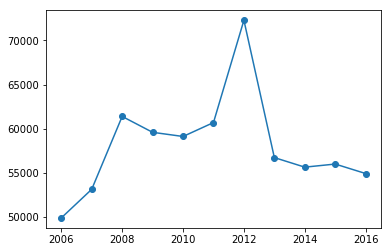

In [493]:
plt.plot(df.index,df.Revenue,'o-')
plt.show()

In [494]:
df

,Revenue,GrossMargin,OperatingIncome,OperatingMargin,NetIncome
2006,49880.0,NaN,5477.0,11.0,3519.0
2007,53124.0,NaN,5057.0,9.5,3923.0
2008,61383.0,NaN,3834.0,6.2,1579.0
2009,59583.0,NaN,4721.0,7.9,2564.0
2010,59111.0,NaN,3978.0,6.7,2430.0
2011,60688.0,NaN,1180.0,1.9,702.0
2012,72286.0,NaN,5349.0,7.4,3188.0
2013,56718.0,NaN,4398.0,7.8,3304.0
2014,55634.0,NaN,4027.0,7.2,3152.0
2015,55985.0,NaN,4819.0,8.6,3107.0


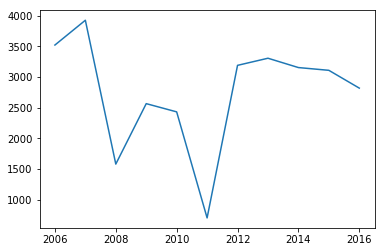

In [495]:
plt.plot(df.index,df.NetIncome)
plt.show()

In [552]:
df = s.keyratios
df = df.transpose()
df = replace_keyratio_names(df)

ValueError: could not convert string to float: TTM

In [508]:
cols = np.array(df[df.index=='year'])[0]

In [509]:
df.columns = cols

In [517]:
len(df[1])

100

In [526]:
len(df[0]), len(df[1])

(101, 100)

In [533]:
for i in range(len(df[0])):
    print 'NOM: {0} -- NEW: {1}'.format(df[0][i],df[1][i])

NOM: Revenue EUR Mil -- NEW: Revenue
NOM: Gross Margin % -- NEW: GrossMargin
NOM: Operating Income EUR Mil -- NEW: OperatingIncome
NOM: Operating Margin % -- NEW: OperatingMargin
NOM: Net Income EUR Mil -- NEW: NetIncome
NOM: Earnings Per Share EUR -- NEW: EarningsPerShare
NOM: Dividends EUR -- NEW: Dividends
NOM: Payout Ratio % * -- NEW: PayoutRatio*
NOM: Shares Mil -- NEW: Shares
NOM: Book Value Per Share * EUR -- NEW: BookValuePerShare*
NOM: Operating Cash Flow EUR Mil -- NEW: OperatingCashFlow
NOM: Cap Spending EUR Mil -- NEW: CapSpending
NOM: Free Cash Flow EUR Mil -- NEW: FreeCashFlow
NOM: Free Cash Flow Per Share * EUR -- NEW: FreeCashFlowPerShare*
NOM: Working Capital EUR Mil -- NEW: WorkingCapital
NOM: Key Ratios -&gt; Profitability -- NEW: KeyRatios-&gt;Profitability
NOM: Margins % of Sales -- NEW: MarginsofSales
NOM: Revenue -- NEW: Revenue
NOM: COGS -- NEW: COGS
NOM: Gross Margin -- NEW: GrossMargin
NOM: SG&amp;A; -- NEW: SG&amp;A;
NOM: R&amp;D; -- NEW: R&amp;D;
NOM: Other 

IndexError: list index out of range

In [447]:
df = s.keyratios
df = df.transpose()
replace_keyratio_names(df)

Revenue USD Mil
Gross Margin %
Operating Income USD Mil
Operating Margin %
Net Income USD Mil
Earnings Per Share USD
Dividends USD
Payout Ratio % *
Shares Mil
Book Value Per Share * USD
Operating Cash Flow USD Mil
Cap Spending USD Mil
Free Cash Flow USD Mil
Free Cash Flow Per Share * USD
Working Capital USD Mil
Key Ratios -&gt; Profitability
Margins % of Sales
Revenue
COGS
Gross Margin
SG&amp;A;
R&amp;D;
Other
Operating Margin
Net Int Inc &amp; Other
EBT Margin
Profitability
Tax Rate %
Net Margin %
Asset Turnover (Average)
Return on Assets %
Financial Leverage (Average)
Return on Equity %
Return on Invested Capital %
Interest Coverage
Key Ratios -&gt; Growth
nan
attributeerror
Revenue %
Year over Year
3-Year Average
5-Year Average
10-Year Average
Operating Income %
Year over Year
3-Year Average
5-Year Average
10-Year Average
Net Income %
Year over Year
3-Year Average
5-Year Average
10-Year Average
EPS %
Year over Year
3-Year Average
5-Year Average
10-Year Average
Key Ratios -&gt; Cash 

ValueError: Length mismatch: Expected axis has 101 elements, new values have 100 elements

In [448]:
s.switch_isin('DE0008430026')

In [449]:
s.

<__main__.stocks instance at 0x7f91b08aa320>

AED
ARS
AUD
BDT
BGN
BRL
CAD
CHF
CNY
COP
CZK
DKK
EGP
EUR
GBP
GEL
GHS
HKD
HUF
IDR
ILS
INR
JMD
JPY
KRW
KWD
KZT
MAD
MXN
MYR
NGN
NOK
NZD
OMR
PEN
PHP
PKR
PLN
RON
RUB
SAR
SEK
SGD
THB
TRY
TWD
UAH
USD
VND
ZAR


In [380]:
currencies

,currency
0,AED
1,ARS
2,AUD
3,BDT
4,BGN
5,BRL
6,CAD
7,CHF
8,CNY
9,COP


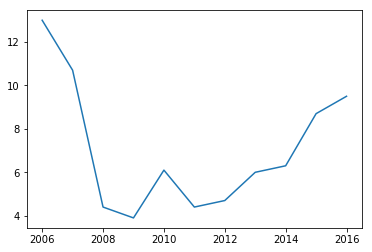

In [361]:
plt.plot(df.index,df.opmargin)
plt.show()

In [356]:
df.opmargin

2006    13.0
2007    10.7
2008     4.4
2009     3.9
2010     6.1
2011     4.4
2012     4.7
2013     6.0
2014     6.3
2015     8.7
2016     9.5
Name: opmargin, dtype: float64

In [329]:
np.array(df[df.index=='year'])[0][1:]

array(['Gross Margin %', 'Operating Income USD Mil', 'Operating Margin %',
       'Net Income USD Mil'], dtype=object)

In [336]:
df

,Revenue USD Mil,Gross Margin %,Operating Income USD Mil,Operating Margin %,Net Income USD Mil
2006,"2,630",43.2,341,13.0,328
2007,"3,028",41.3,325,10.7,310
2008,"2,942",37.5,130,4.4,-34
2009,"2,376",36.9,93,3.9,91
2010,"2,445",39.0,150,6.1,154
2011,"2,573",38.7,112,4.4,78
2012,"2,588",38.9,121,4.7,101
2013,"2,636",40.1,159,6.0,107
2014,"2,695",39.7,170,6.3,125
2015,"2,552",41.8,223,8.7,156


In [114]:
currencies = hdf['currencies']

In [115]:
df = s._get_keyratio('Revenue USD Mil')

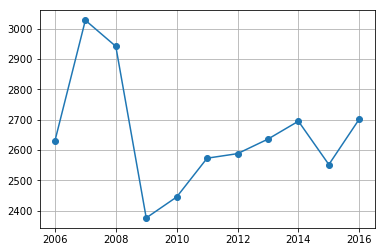

In [116]:
plt.plot(df.year,df.value,'o-')
plt.grid()
plt.show()

In [189]:
s.get_all_keyratios()

In [190]:
s.sd.grossmargin

5

In [60]:
df.value.replace?

In [69]:
import re 

In [94]:
s.fixed_keyratio_names

['Gross Margin %']

In [143]:
df = pd.DataFrame()

In [146]:
df['grossmargin'] = 4

In [148]:
df.grossmargin

Series([], Name: grossmargin, dtype: int64)

In [150]:
class test:
    def __init__(self):
        pass

In [151]:
t = test()

In [152]:
setattr(t,'ttt',5)

In [153]:
t.ttt

5

In [35]:
ddd = hdf['currencies']

NameError: name 'hdf' is not defined

In [122]:
s.keyratios[s.keyratios.index==0]

,0,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Revenue USD Mil,"1,173","1,330","1,600","1,276","1,431","1,843","1,804","1,881","1,927","1,776","1,765"


In [105]:
# identify absolute revenues 

for j in s.keyratios.itertuples():
    print j[0], j[1]

0 Revenue USD Mil
1 Gross Margin %
2 Operating Income USD Mil
3 Operating Margin %
4 Net Income USD Mil
5 Earnings Per Share USD
6 Dividends USD
7 Payout Ratio % *
8 Shares Mil
9 Book Value Per Share * USD
10 Operating Cash Flow USD Mil
11 Cap Spending USD Mil
12 Free Cash Flow USD Mil
13 Free Cash Flow Per Share * USD
14 Working Capital USD Mil
15 Key Ratios -&gt; Profitability
16 Margins % of Sales
17 Revenue
18 COGS
19 Gross Margin
20 SG&amp;A;
21 R&amp;D;
22 Other
23 Operating Margin
24 Net Int Inc &amp; Other
25 EBT Margin
26 Profitability
27 Tax Rate %
28 Net Margin %
29 Asset Turnover (Average)
30 Return on Assets %
31 Financial Leverage (Average)
32 Return on Equity %
33 Return on Invested Capital %
34 Interest Coverage
35 Key Ratios -&gt; Growth
36 nan
37 Revenue %
38 Year over Year
39 3-Year Average
40 5-Year Average
41 10-Year Average
42 Operating Income %
43 Year over Year
44 3-Year Average
45 5-Year Average
46 10-Year Average
47 Net Income %
48 Year over Year
49 3-Year Ave

In [115]:
for i,j in s.keyratios.iteritems():
    print i

0
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [121]:
s.keyratios

,0,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Revenue USD Mil,"1,173","1,330","1,600","1,276","1,431","1,843","1,804","1,881","1,927","1,776","1,765"
1,Gross Margin %,10.7,10.6,10.6,18.3,16.5,13.9,16.2,15.0,12.9,17.4,19.5
2,Operating Income USD Mil,16,35,71,105,108,118,129,109,91,123,136
3,Operating Margin %,1.4,2.6,4.4,8.2,7.5,6.4,7.1,5.8,4.7,6.9,7.7
4,Net Income USD Mil,7,15,37,63,65,72,79,73,57,76,89
5,Earnings Per Share USD,0.32,0.75,1.76,2.92,2.95,3.21,3.49,3.18,2.49,3.32,3.87
6,Dividends USD,0.40,0.41,0.42,0.45,0.49,0.53,0.50,0.65,0.69,0.73,0.76
7,Payout Ratio % *,NaN,55.0,24.1,15.4,16.6,17.3,14.3,16.6,25.3,23.8,19.6
8,Shares Mil,19,20,21,22,22,22,23,23,23,23,23
9,Book Value Per Share * USD,NaN,10.30,10.10,13.85,16.65,18.71,21.74,23.79,25.81,24.76,28.49


read the essential data from the HDF storage

In [7]:
get_factor('Mil EUR')

'Mil'

In [12]:
def get_currency(string):
    for _,j in hdf['currencies'].iterrows():
        if ' '+j[0] in string:
            return j[0]
        
def get_factor(string, factors = ['Mil']):
    for j in factors:
        if j in string:
            return j
        
def get_factor_num(string):
    if string=='Mil':
        return 1e6

In [15]:
# identify absolute revenues 

for i,j in s.kr.iterrows():
    try:
        if 'Revenue' in j[0] and 'Revenue'!=j[0] and '%' not in j[0]:
            fac = get_factor(j[0])
            num = get_factor_num(fac)
            for jj in j.keys()[1:]:
                try:
                    val = int(j[jj].replace(',',''))
                    print jj, val*num
                except AttributeError:
                    print jj, 'NaN'
            break
    except TypeError:
        continue

2006 99222000000.0
2007 99555000000.0
2008 98469000000.0
2009 NaN
2010 97761000000.0
2011 1.0654e+11
2012 1.14297e+11
2013 1.17982e+11
2014 1.29872e+11
2015 1.49467e+11
2016 1.52688e+11


### Gross margin

In [18]:
for k in aa.keys()[1:]:
    print k,float(aa[k].replace(',',''))

2006 20.6
2007 24.1
2008 21.9
2009 nan
2010 23.3
2011 24.0
2012 22.3
2013 21.3
2014 21.7
2015 21.3
2016 20.7


### Operating Income

In [142]:
# identify absolute revenues 

for i,j in s.kr.iterrows():
    try:
        if 'Operating Income' in j[0]:
            fac = get_factor(j[0])
            cur = get_currency(j[0])
            print 'Currency', cur
            for jj in j.keys()[1:]:
                try:
                    val = int(j[jj].replace(',',''))
                    print jj, val*fac
                except AttributeError:
                    print jj, 'NaN'
            break
    except TypeError:
        continue

Currency EUR
2006 4661000000.0
2007 7875000000.0
2008 2730000000.0
2009 -1513000000.0
2010 7274000000.0
2011 8449000000.0
2012 8116000000.0
2013 10139000000.0
2014 10173000000.0
2015 12744000000.0
2016 12002000000.0


### Net Income

In [161]:
def get_keyratios_string(string):
    for i,j in s.kr.iterrows():
        try:
            if string in j[0]:
                fac = get_factor(j[0])
                cur = get_currency(j[0])
                print 'Parameter:', string
                print 'Currency: ', fac, cur
                for jj in j.keys()[1:]:
                    try:
                        val = float(j[jj].replace(',',''))
                        print jj, val
                    except AttributeError:
                        print jj, 'NaN'
                break
        except TypeError:
            continue

In [195]:
def keyratio_to_df(string):
    output = []
    for i,j in s.kr.iterrows():
        try:
            if string in j[0]:
                fac = get_factor(j[0])
                cur = get_currency(j[0])
                print 'Parameter:', string
                print 'Currency: ', fac, cur
                for jj in j.keys()[1:]:
                    try:
                        val = float(j[jj].replace(',',''))
                        output.append([jj,val])
                    except AttributeError:
                        output.append([jj, 'NaN'])
                break
        except TypeError:
            continue
    return pd.DataFrame(np.array(output),columns=['year','val'])

In [196]:
keyratio_to_df('Net Income')

Parameter: Net Income
Currency:  Mil EUR


,year,val
0,2006.0,3744.0
1,2007.0,3986.0
2,2008.0,1348.0
3,2009.0,-2640.0
4,2010.0,4498.0
5,2011.0,5667.0
6,2012.0,6428.0
7,2013.0,6842.0
8,2014.0,6962.0
9,2015.0,8424.0


sqltable UNITS:
store Mil and EUR/USD etc for the individual parameters for the individual stocks

In [167]:
get_keyratios_string('Earnings Per Share')

Parameter: Earnings Per Share
Currency:  None EUR
2006 3.64
2007 3.81
2008 1.4
2009 -2.63
2010 4.28
2011 5.31
2012 6.02
2013 6.4
2014 6.51
2015 7.87
2016 7.64


In [168]:
get_keyratios_string('Dividends')

Parameter: Dividends
Currency:  None EUR
2006 NaN
2007 NaN
2008 NaN
2009 NaN
2010 NaN
2011 1.85
2012 2.2
2013 2.2
2014 2.25
2015 2.45
2016 3.25


In [169]:
get_keyratios_string('Payout Ratio')

Parameter: Payout Ratio
Currency:  None None
2006 NaN
2007 NaN
2008 NaN
2009 NaN
2010 NaN
2011 39.5
2012 42.0
2013 32.0
2014 32.1
2015 33.9
2016 42.5


In [170]:
get_keyratios_string('Shares')

Parameter: Shares
Currency:  Mil None
2006 1029.0
2007 1046.0
2008 959.0
2009 1003.0
2010 1052.0
2011 1067.0
2012 1067.0
2013 1069.0
2014 1069.0
2015 1069.0
2016 1071.0


In [171]:
get_keyratios_string('Book Value Per Share')

Parameter: Book Value Per Share
Currency:  None EUR
2006 NaN
2007 36.73
2008 35.45
2009 29.73
2010 32.28
2011 35.72
2012 38.64
2013 38.42
2014 41.38
2015 46.6
2016 50.19


In [172]:
get_keyratios_string('Operating Cash Flow')

Parameter: Operating Cash Flow
Currency:  Mil EUR
2006 14016.0
2007 13108.0
2008 3212.0
2009 10961.0
2010 8544.0
2011 -696.0
2012 -1100.0
2013 3285.0
2014 -1274.0
2015 222.0
2016 2175.0


In [175]:
get_keyratios_string('Free Cash Flow Per Share')

Parameter: Free Cash Flow Per Share
Currency:  None EUR
2006 NaN
2007 -12.73
2008 -2.59
2009 2.08
2010 4.96
2011 -4.75
2012 -7.6
2013 -3.92
2014 -2.87
2015 -9.25
2016 NaN


In [177]:
get_keyratios_string('Working Capital')

Parameter: Working Capital
Currency:  Mil EUR
2006 -451.0
2007 13312.0
2008 3215.0
2009 6742.0
2010 3864.0
2011 6263.0
2012 8740.0
2013 11333.0
2014 10171.0
2015 14766.0
2016 NaN


http://www.investopedia.com/terms/c/cogs.asp

In [179]:
get_keyratios_string('COGS')

Parameter: COGS
Currency:  None None
2006 79.4
2007 75.86
2008 78.11
2009 NaN
2010 76.71
2011 76.05
2012 77.71
2013 78.7
2014 78.3
2015 78.73
2016 79.28


In [180]:
get_keyratios_string('Gross Margin')

Parameter: Gross Margin
Currency:  None None
2006 20.6
2007 24.1
2008 21.9
2009 NaN
2010 23.3
2011 24.0
2012 22.3
2013 21.3
2014 21.7
2015 21.3
2016 20.7


In [181]:
get_keyratios_string('Return on Equity')

Parameter: Return on Equity
Currency:  None None
2006 9.14
2007 11.24
2008 3.11
2009 -8.58
2010 13.5
2011 14.91
2012 14.6
2013 15.81
2014 16.13
2015 17.33
2016 15.81


In [194]:
keyratio_to_df('Return on Equity')

Parameter: Return on Equity
Currency:  None None


,year,val
0,2006.0,9.14
1,2007.0,11.24
2,2008.0,3.11
3,2009.0,-8.58
4,2010.0,13.50
5,2011.0,14.91
6,2012.0,14.60
7,2013.0,15.81
8,2014.0,16.13
9,2015.0,17.33


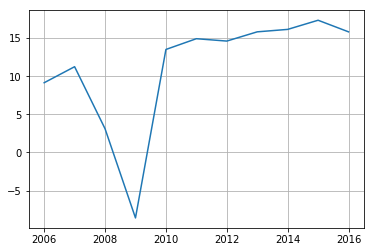

In [193]:
plt.plot(df.year,df.val)
plt.grid()
plt.show()

In [115]:
s.kr[0]

0                         Revenue EUR Mil
1                          Gross Margin %
2                Operating Income EUR Mil
3                      Operating Margin %
4                      Net Income EUR Mil
5                  Earnings Per Share EUR
6                           Dividends EUR
7                        Payout Ratio % *
8                              Shares Mil
9              Book Value Per Share * EUR
10            Operating Cash Flow EUR Mil
11                   Cap Spending EUR Mil
12                 Free Cash Flow EUR Mil
13         Free Cash Flow Per Share * EUR
14                Working Capital EUR Mil
15         Key Ratios -&gt; Profitability
16                     Margins % of Sales
17                                Revenue
18                                   COGS
19                           Gross Margin
20                              SG&amp;A;
21                               R&amp;D;
22                                  Other
23                       Operating

In [27]:
df[df['a'] == 'Shares Mil']

,a,b,c,d,e,f,g,h,i,j,k,l
9,Shares Mil,228,215,201,195,185,178,178,179,172,166,NaN


In [31]:
df = df.transpose()

In [42]:
df

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
a,year,Revenue EUR Mil,Gross Margin %,Operating Income EUR Mil,Operating Margin %,Net Income EUR Mil,Earnings Per Share EUR,Dividends EUR,Payout Ratio % *,Shares Mil,...,Key Ratios -&gt; Efficiency Ratios,Efficiency,Days Sales Outstanding,Days Inventory,Payables Period,Cash Conversion Cycle,Receivables Turnover,Inventory Turnover,Fixed Assets Turnover,Asset Turnover
b,2006-12,"49,880",NaN,"5,477",11.0,"3,519",15.05,NaN,NaN,228,...,NaN,2006-12,NaN,NaN,NaN,NaN,NaN,NaN,9.48,0.23
c,2007-12,"53,124",NaN,"5,057",9.5,"3,923",17.83,NaN,NaN,215,...,NaN,2007-12,NaN,NaN,NaN,NaN,NaN,NaN,12.54,0.24
d,2008-12,"61,383",NaN,"3,834",6.2,"1,579",7.74,NaN,NaN,201,...,NaN,2008-12,NaN,NaN,NaN,NaN,NaN,NaN,16.12,0.28
e,2009-12,"59,583",NaN,"4,721",7.9,"2,564",12.95,NaN,NaN,195,...,NaN,2009-12,NaN,NaN,NaN,NaN,NaN,NaN,15.24,0.27
f,2010-12,"59,111",NaN,"3,978",6.7,"2,430",13.06,NaN,NaN,185,...,NaN,2010-12,NaN,NaN,NaN,NaN,NaN,NaN,15.39,0.28
g,2011-12,"60,688",NaN,"1,180",1.9,702,3.94,NaN,NaN,178,...,NaN,2011-12,NaN,NaN,NaN,NaN,NaN,NaN,14.97,0.25
h,2012-12,"72,286",NaN,"5,349",7.4,"3,188",17.94,NaN,NaN,178,...,NaN,2012-12,NaN,NaN,NaN,NaN,NaN,NaN,17.29,0.26
i,2013-12,"56,718",NaN,"4,398",7.8,"3,304",18.45,7.00,47.9,179,...,NaN,2013-12,NaN,NaN,NaN,NaN,NaN,NaN,18.42,0.27
j,2014-12,"55,634",NaN,"4,027",7.2,"3,152",18.31,7.25,35.0,172,...,NaN,2014-12,NaN,NaN,NaN,NaN,NaN,NaN,14.85,0.21


In [47]:
df.columns = df[df.index=='a'].transpose()

In [48]:
df

,"(year,)","(Revenue EUR Mil,)","(Gross Margin %,)","(Operating Income EUR Mil,)","(Operating Margin %,)","(Net Income EUR Mil,)","(Earnings Per Share EUR,)","(Dividends EUR,)","(Payout Ratio % *,)","(Shares Mil,)",...,"(Key Ratios -&gt; Efficiency Ratios,)","(Efficiency,)","(Days Sales Outstanding,)","(Days Inventory,)","(Payables Period,)","(Cash Conversion Cycle,)","(Receivables Turnover,)","(Inventory Turnover,)","(Fixed Assets Turnover,)","(Asset Turnover,)"
a,year,Revenue EUR Mil,Gross Margin %,Operating Income EUR Mil,Operating Margin %,Net Income EUR Mil,Earnings Per Share EUR,Dividends EUR,Payout Ratio % *,Shares Mil,...,Key Ratios -&gt; Efficiency Ratios,Efficiency,Days Sales Outstanding,Days Inventory,Payables Period,Cash Conversion Cycle,Receivables Turnover,Inventory Turnover,Fixed Assets Turnover,Asset Turnover
b,2006-12,"49,880",NaN,"5,477",11.0,"3,519",15.05,NaN,NaN,228,...,NaN,2006-12,NaN,NaN,NaN,NaN,NaN,NaN,9.48,0.23
c,2007-12,"53,124",NaN,"5,057",9.5,"3,923",17.83,NaN,NaN,215,...,NaN,2007-12,NaN,NaN,NaN,NaN,NaN,NaN,12.54,0.24
d,2008-12,"61,383",NaN,"3,834",6.2,"1,579",7.74,NaN,NaN,201,...,NaN,2008-12,NaN,NaN,NaN,NaN,NaN,NaN,16.12,0.28
e,2009-12,"59,583",NaN,"4,721",7.9,"2,564",12.95,NaN,NaN,195,...,NaN,2009-12,NaN,NaN,NaN,NaN,NaN,NaN,15.24,0.27
f,2010-12,"59,111",NaN,"3,978",6.7,"2,430",13.06,NaN,NaN,185,...,NaN,2010-12,NaN,NaN,NaN,NaN,NaN,NaN,15.39,0.28
g,2011-12,"60,688",NaN,"1,180",1.9,702,3.94,NaN,NaN,178,...,NaN,2011-12,NaN,NaN,NaN,NaN,NaN,NaN,14.97,0.25
h,2012-12,"72,286",NaN,"5,349",7.4,"3,188",17.94,NaN,NaN,178,...,NaN,2012-12,NaN,NaN,NaN,NaN,NaN,NaN,17.29,0.26
i,2013-12,"56,718",NaN,"4,398",7.8,"3,304",18.45,7.00,47.9,179,...,NaN,2013-12,NaN,NaN,NaN,NaN,NaN,NaN,18.42,0.27
j,2014-12,"55,634",NaN,"4,027",7.2,"3,152",18.31,7.25,35.0,172,...,NaN,2014-12,NaN,NaN,NaN,NaN,NaN,NaN,14.85,0.21


In [7]:
maxentries = 0
with open('ms_keyratios/MUV2.csv') as f:
    for line in f:
        entries = line.split(',')
        if len(entries)>maxentries:
            maxentries = len(entries)
            print line

???Growth Profitability and Financial Ratios for Munchener Ruckversicherungs-Gesellschaft AG

,2006-12,2007-12,2008-12,2009-12,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,TTM

Revenue EUR Mil,"49,880","53,124","61,383","59,583","59,111","60,688","72,286","56,718","55,634","55,985","54,911"



In [5]:
maxentries

23

line

In [6]:
line

'Asset Turnover,0.23,0.24,0.28,0.27,0.28,0.25,0.26,0.27,0.21,0.20,0.20\n'

## Stock price